# Import Libraries

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, silhouette_score, davies_bouldin_score, silhouette_samples

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle

# Data Loading

In [2]:
# Convert CSV to Excel (If required)
# 1. Define the path
folder_path = Path("../../Profile_Data")
file_to_convert = "StackOverflow-20K-Formatted.csv"
csv_path = folder_path / file_to_convert

if csv_path.exists():
    # 2. READ: The key is 'sep=;' which matches the file format
    df = pd.read_csv(csv_path, sep=';')
    
    # 3. CONVERT: Change extension to .xlsx
    xlsx_path = csv_path.with_suffix('.xlsx')
    
    # 4. SAVE: index=False
    df.to_excel(xlsx_path, index=False)

    # 5. Load StackOverflow data
    df = pd.read_excel("../../Profile_Data/StackOverflow-20K-Formatted.xlsx")
    print(f"Successfully converted to Excel!")
    print(f"Dataset: {df.shape}") # (20000, 7)
    print(f"\nColumns: {list(df.columns)}")
    display(df.head()) # Shows the first 5 rows in the formatted table
else:
    print(f"Error: Could not find {csv_path}")

Successfully converted to Excel!
Dataset: (20000, 7)

Columns: ['User_ID', 'Display_Name', 'Reputation', 'Gold_Badges', 'Silver_Badges', 'Bronze_Badges', 'Link']


,User_ID,Display_Name,Reputation,Gold_Badges,Silver_Badges,Bronze_Badges,Link
0,23354,Marc Gravell,1071279,273,2638,2968,https://stackoverflow.com/users/23354/marc-gra...
1,29407,Darin Dimitrov,1042375,277,3325,2951,https://stackoverflow.com/users/29407/darin-di...
2,115145,CommonsWare,1011493,195,2451,2684,https://stackoverflow.com/users/115145/commons...
3,893,Greg Hewgill,1004481,193,1188,1304,https://stackoverflow.com/users/893/greg-hewgill
4,19068,Quentin,949043,137,1280,1408,https://stackoverflow.com/users/19068/quentin


# Data Cleaning

In [3]:
def clean_data(df):
    print(f"Original shape: {df.shape}")
    
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"After removing duplicates: {df.shape}")
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    
    # Clean text columns (remove special characters)
    def clean_text(text):
        if pd.isna(text):
            return text
        return re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    
    # Apply to text columns that typically have special characters
    text_columns = ['name', 'location', 'username', 'bio', 'company']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].apply(clean_text)
            print(f"   Cleaned special chars from: {col}")

    # Fill missing values
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna('Unknown')
    
    # Remove completely empty columns
    df = df.dropna(axis=1, how='all')
    
    # Remove completely empty rows
    df = df.dropna(axis=0, how='all')
    
    print(f"Final cleaned shape: {df.shape}")
    
    return df


# Clean the data
stack = clean_data(df)
df

Original shape: (20000, 7)
After removing duplicates: (20000, 7)
Final cleaned shape: (20000, 7)


,User_ID,Display_Name,Reputation,Gold_Badges,Silver_Badges,Bronze_Badges,Link
0,23354,Marc Gravell,1071279,273,2638,2968,https://stackoverflow.com/users/23354/marc-gra...
1,29407,Darin Dimitrov,1042375,277,3325,2951,https://stackoverflow.com/users/29407/darin-di...
2,115145,CommonsWare,1011493,195,2451,2684,https://stackoverflow.com/users/115145/commons...
3,893,Greg Hewgill,1004481,193,1188,1304,https://stackoverflow.com/users/893/greg-hewgill
4,19068,Quentin,949043,137,1280,1408,https://stackoverflow.com/users/19068/quentin
...,...,...,...,...,...,...,...
19995,6309,VonC,1364061,569,4791,5750,https://stackoverflow.com/users/6309/vonc
19996,1144035,Gordon Linoff,1276142,62,708,858,https://stackoverflow.com/users/1144035/gordon...
19997,100297,Martijn Pieters,1139425,326,4244,3451,https://stackoverflow.com/users/100297/martijn...
19998,157882,BalusC,1114886,377,3658,3595,https://stackoverflow.com/users/157882/balusc


## Features

In [4]:
all_features = ['Reputation', 'Gold_Badges', 'Silver_Badges', 'Bronze_Badges']
X = df[all_features]

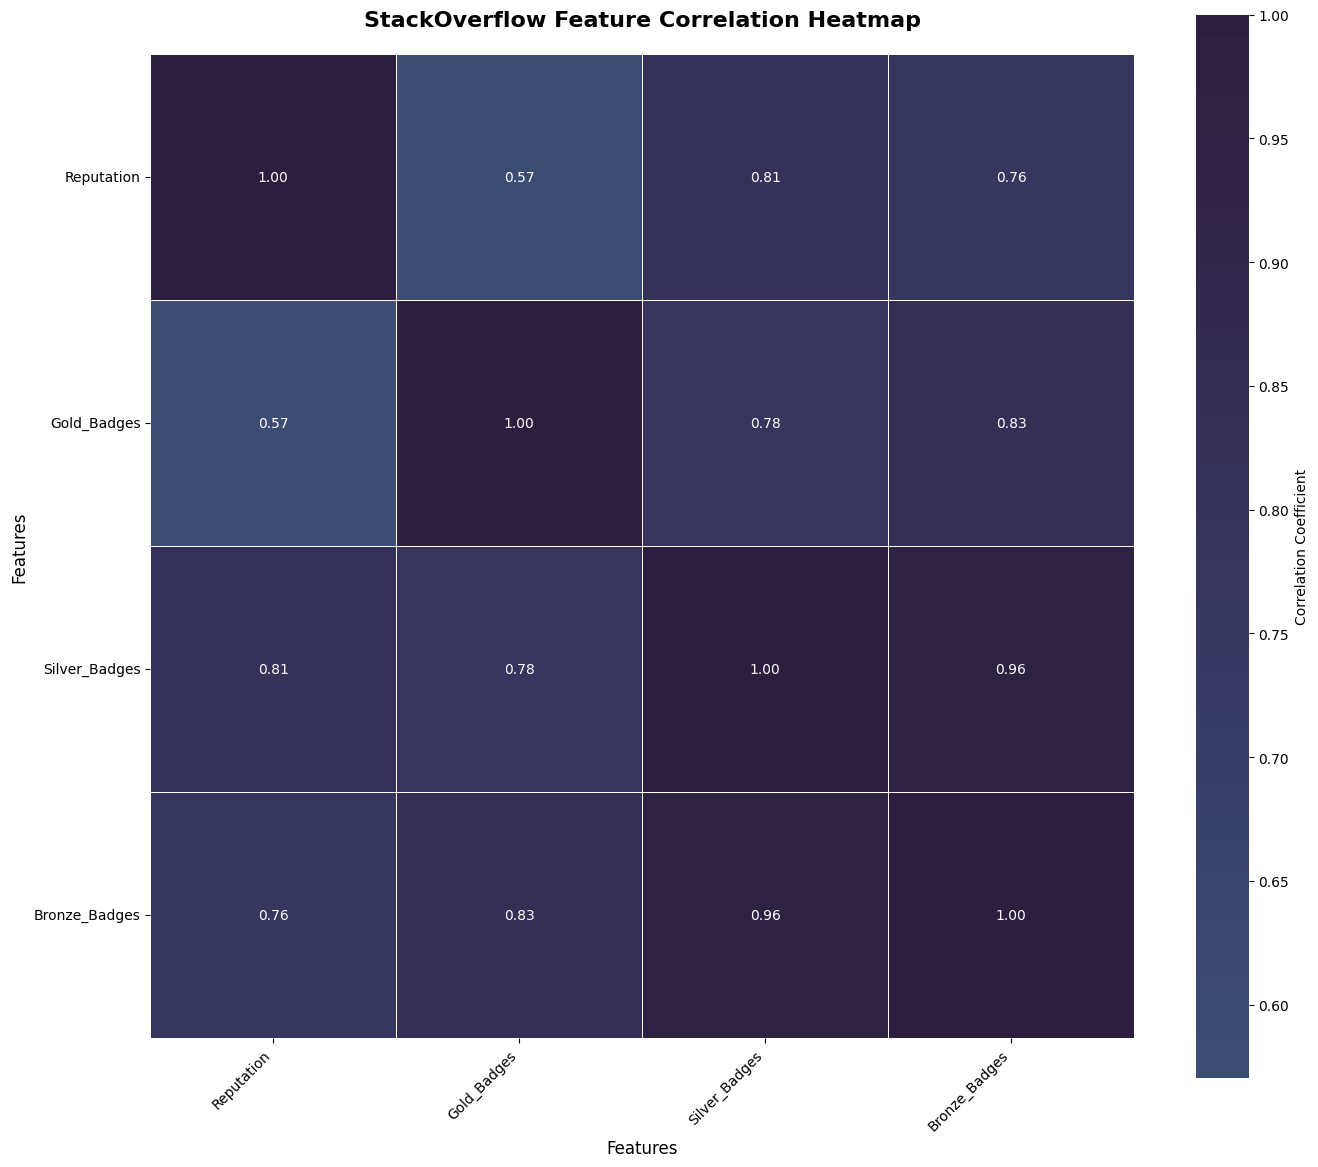

In [5]:
X_with_target = X.copy()

correlation_matrix = X_with_target.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix, 
    annot=True,
    fmt='.2f',
    cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('StackOverflow Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../ML_Visualizations/stackoverflow/stackoverflow_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Scaling

In [6]:
# Scale the data (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[16.3894125  10.75259553 18.66817953 17.78285089]
 [15.92966058 10.9211077  23.72286947 17.67618072]
 [15.43844626  7.4666081  17.29230323 16.00083156]
 ...
 [17.47335431 12.98538186 30.48452894 20.8135387 ]
 [17.08303282 15.1339121  26.17295935 21.71709779]
 [16.56480983  7.71937636 14.17266927 11.50186023]]


# K-Means

Testing different numbers of clusters...


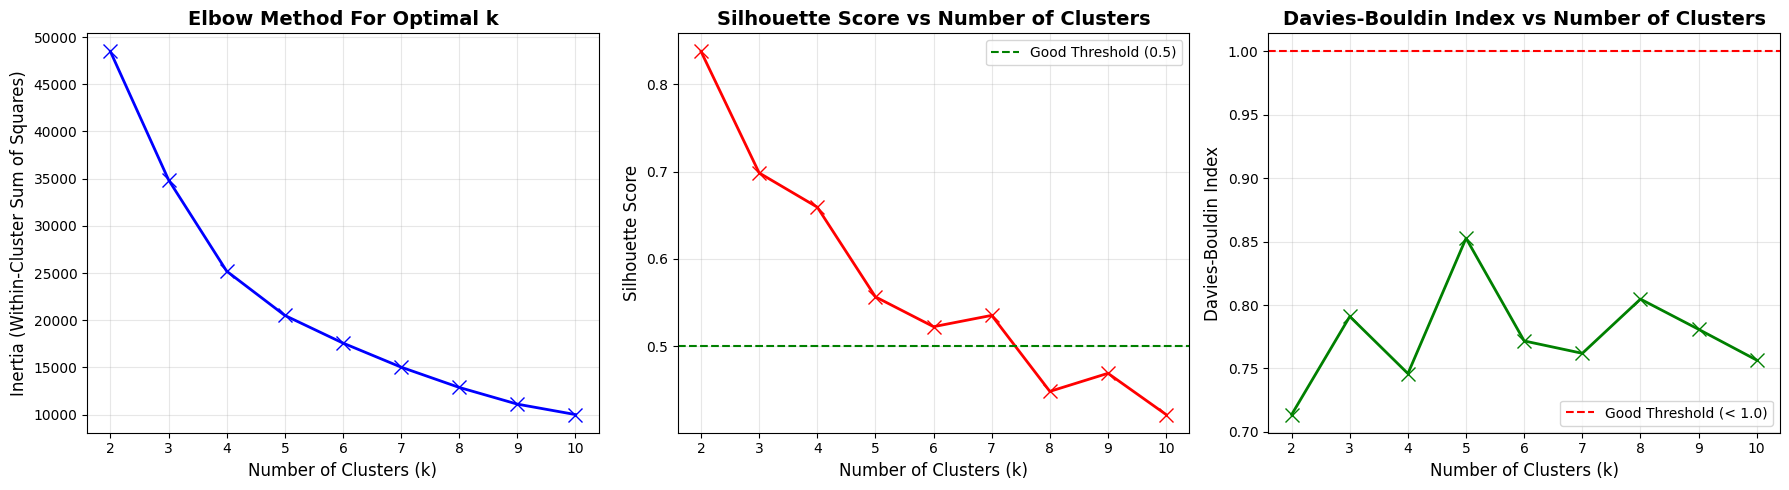


 Optimal number of clusters based on Silhouette Score: 2
   Silhouette Score: 0.838
   Davies-Bouldin Index: 0.714


In [7]:
# Elbow Method to find optimal clusters
print("Testing different numbers of clusters...")
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans_temp.labels_))

# Plot Elbow + Silhouette + Davies-Bouldin
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Elbow Plot
ax1.plot(K_range, inertias, 'bx-', linewidth=2, markersize=10)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette Score Plot
ax2.plot(K_range, silhouette_scores, 'rx-', linewidth=2, markersize=10)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.axhline(y=0.5, color='green', linestyle='--', label='Good Threshold (0.5)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Davies-Bouldin Index Plot
ax3.plot(K_range, davies_bouldin_scores, 'gx-', linewidth=2, markersize=10)
ax3.set_xlabel('Number of Clusters (k)', fontsize=12)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax3.set_title('Davies-Bouldin Index vs Number of Clusters', fontsize=14, fontweight='bold')
ax3.axhline(y=1.0, color='red', linestyle='--', label='Good Threshold (< 1.0)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n Optimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.3f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_scores[optimal_k-2]:.3f}")

CLUSTER QUALITY VALIDATION
Number of Clusters: 2
Silhouette Score: 0.838 (Range: -1 to 1, Higher is Better)
Davies-Bouldin Index: 0.714 (Lower is Better)
GOOD: Clusters are well-separated and cohesive


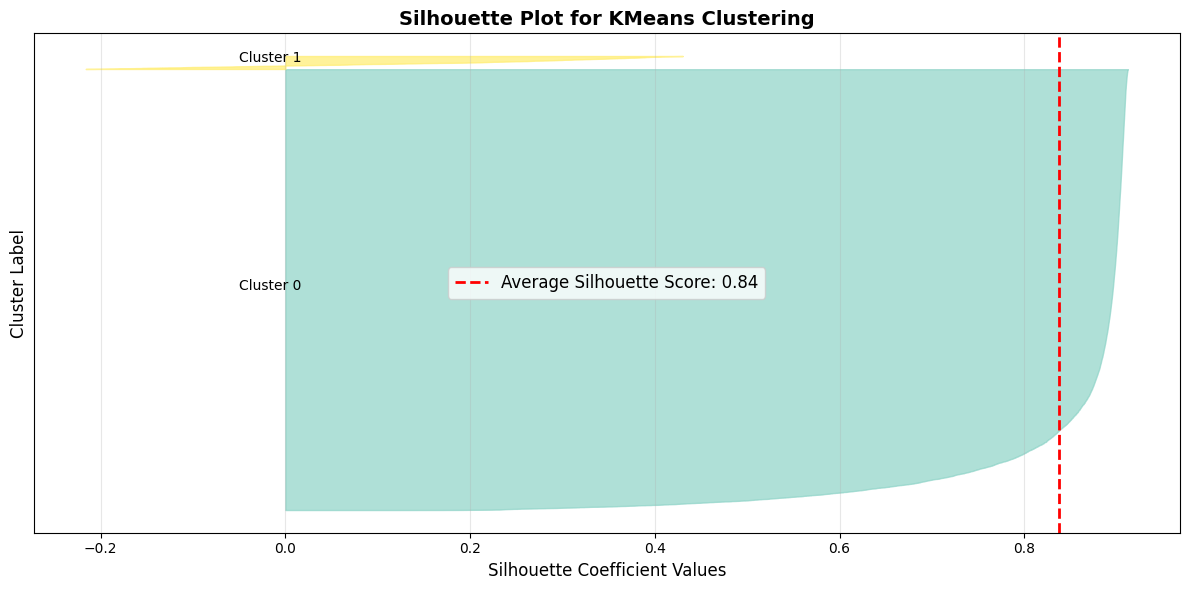


Cluster Distribution:
Cluster 0: 19429 samples (97.1%)
Cluster 1: 571 samples (2.9%)
Recruiter_Label
Bad     19429
Good      571
Name: count, dtype: int64


In [8]:
# applying k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)   # random_state = 42 so results stay consistent
df['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# Cluster Quality Metrics
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)

print("CLUSTER QUALITY VALIDATION")

print(f"Number of Clusters: {kmeans.n_clusters}")
print(f"Silhouette Score: {silhouette_avg:.3f} (Range: -1 to 1, Higher is Better)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (Lower is Better)")

if silhouette_avg > 0.5:
    print("GOOD: Clusters are well-separated and cohesive")
elif silhouette_avg > 0.25:
    print("FAIR: Clusters have some overlap")
else:
    print("POOR: Clusters are not well-defined")

# Silhouette Plot for Visual Validation
fig, ax = plt.subplots(figsize=(12, 6))

silhouette_vals = silhouette_samples(X_scaled, kmeans.labels_)
y_lower = 10

colors = plt.cm.Set3(np.linspace(0, 1, kmeans.n_clusters))

for i in range(kmeans.n_clusters):
    cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label the clusters
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}', fontsize=10)
    
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
           label=f'Average Silhouette Score: {silhouette_avg:.2f}')
ax.set_xlabel("Silhouette Coefficient Values", fontsize=12)
ax.set_ylabel("Cluster Label", fontsize=12)
ax.set_title("Silhouette Plot for KMeans Clustering", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print cluster distribution
print(f"\nCluster Distribution:")
cluster_counts = pd.Series(kmeans.labels_).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(kmeans.labels_)) * 100
    print(f"Cluster {cluster_id}: {count} samples ({percentage:.1f}%)")

# Identify which cluster is Good
# K-means doesn't know Good v/s Bad, it knows Group 0 and Group 1
# check which group has the higher average reputation
cluster_0_avg = df[df['Cluster_Label'] == 0]['Reputation'].mean()
cluster_1_avg = df[df['Cluster_Label'] == 1]['Reputation'].mean()

if cluster_1_avg > cluster_0_avg:
    df['Recruiter_Label'] = df['Cluster_Label'].map({1: 'Good', 0: 'Bad'})
else:
    df['Recruiter_Label'] = df['Cluster_Label'].map({0: 'Good', 1: 'Bad'})

print(df['Recruiter_Label'].value_counts())

C:\Users\Anushka\AppData\Local\Temp\ipykernel_6424\249954357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Recruiter_Label', data=df, palette={'Good': 'green', 'Bad': 'blue'})


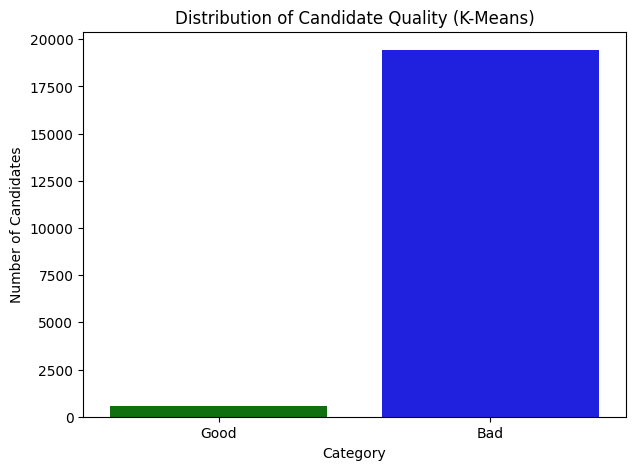

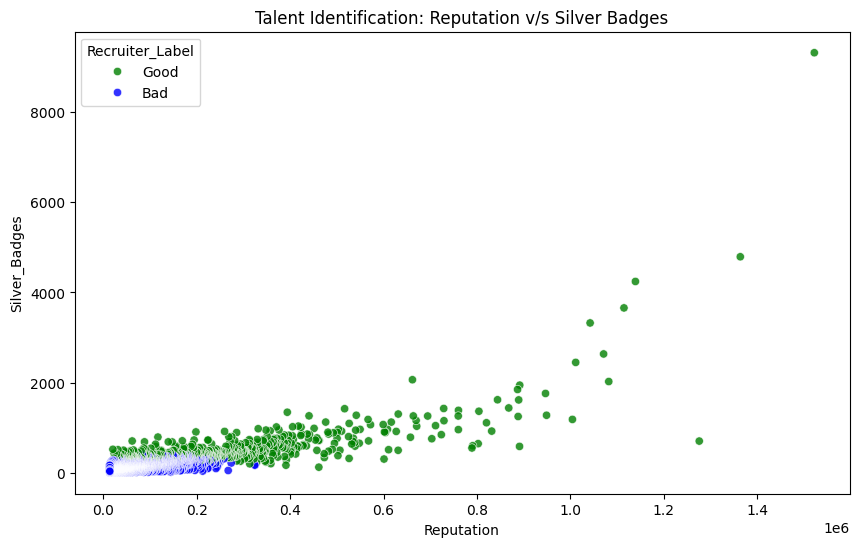

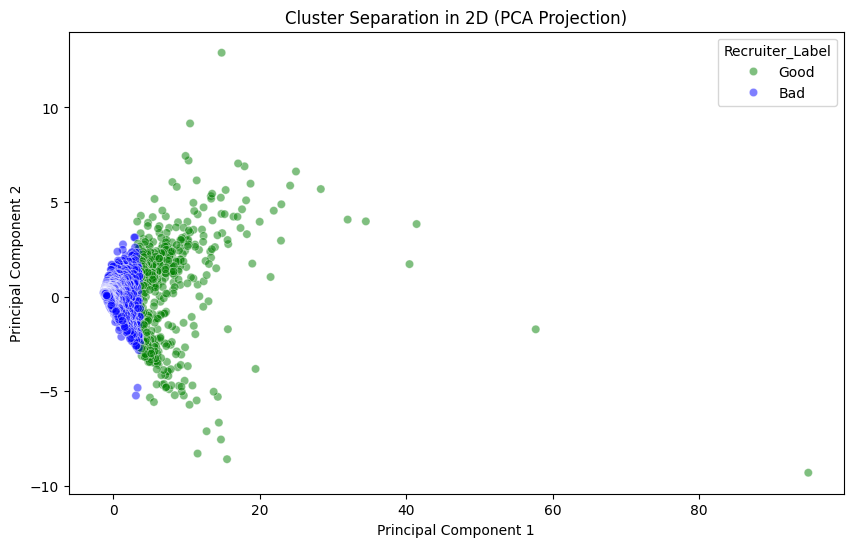

In [9]:
# BAR CHART: Talent Distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Recruiter_Label', data=df, palette={'Good': 'green', 'Bad': 'blue'})
plt.title('Distribution of Candidate Quality (K-Means)')
plt.ylabel('Number of Candidates')
plt.xlabel('Category')
plt.savefig('../ML_Visualizations/stackoverflow/stackoverflow_distribution_counts.png')

# SCATTER PLOT: Reputation v/s Badges
# This shows how the Good group is physically separated in the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Reputation', y='Silver_Badges', hue='Recruiter_Label',
                palette={'Good': 'green', 'Bad': 'blue'}, alpha=0.8)
plt.title('Talent Identification: Reputation v/s Silver Badges')
plt.savefig('../ML_Visualizations/stackoverflow/stackoverflow_feature_scatter.png')

# PCA PLOT: High-Dimensional Separation
# This shows how the AI sees the clusters using all 4 features at once
X_scaled = StandardScaler().fit_transform(df[all_features])

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=df['Recruiter_Label'],
                palette={'Good': 'green', 'Bad': 'blue'}, alpha=0.5)
plt.title('Cluster Separation in 2D (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('../ML_Visualizations/stackoverflow/stackoverflow_pca_cluster_viz.png')

## Train - Test Split

In [10]:
# PREPARE DATA
X = df[all_features]
y = df['Cluster_Label']

# TRAIN/TEST SPLIT
# We split first so the test set remains pure real world data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

# SMOTE

In [11]:
# APPLY SMOTE (To TRAINING only)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

C:\Users\Anushka\AppData\Local\Temp\ipykernel_6424\1354566418.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Bad (0)', 'Good (1)'], y=before_counts.values, ax=ax[0], palette='Blues')
C:\Users\Anushka\AppData\Local\Temp\ipykernel_6424\1354566418.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Bad (0)', 'Good (1)'], y=after_counts.values, ax=ax[1], palette='crest')


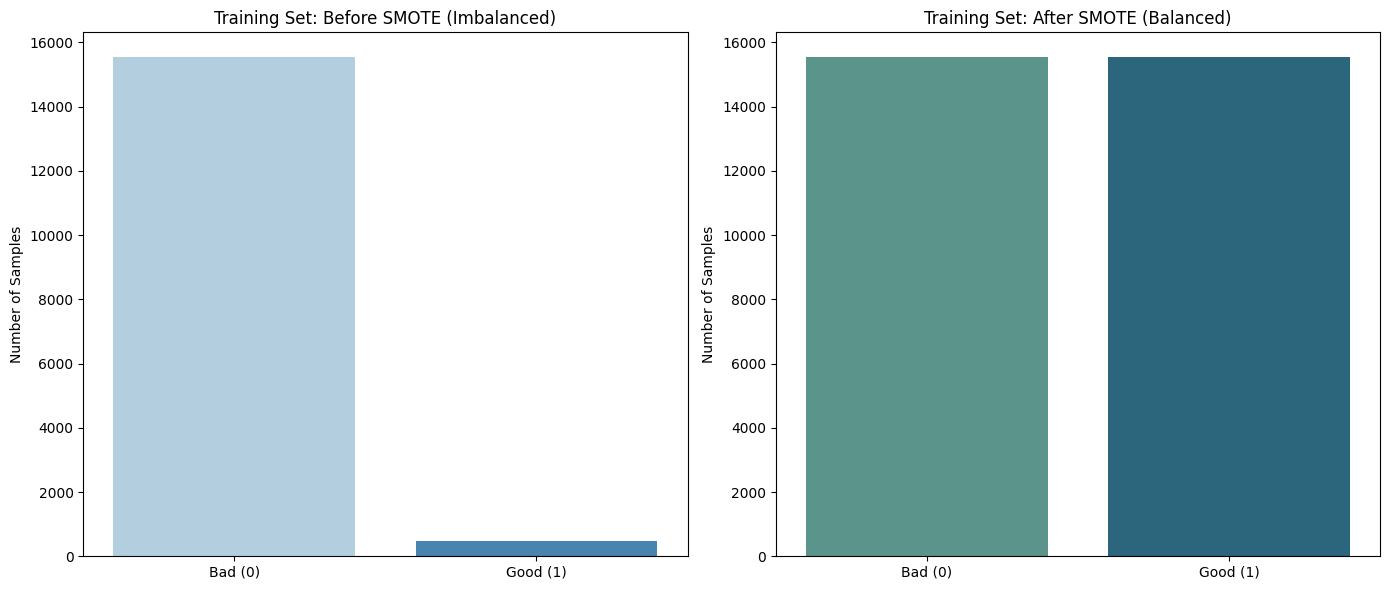

In [12]:
# Visualization plot to show the effect of SMOTE on the training data distribution

before_counts = pd.Series(y_train).value_counts().sort_index()
after_counts = pd.Series(y_train_res).value_counts().sort_index()

# Set up the plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Plot Before SMOTE
sns.barplot(x=['Bad (0)', 'Good (1)'], y=before_counts.values, ax=ax[0], palette='Blues')
ax[0].set_title('Training Set: Before SMOTE (Imbalanced)')
ax[0].set_ylabel('Number of Samples')

# Plot After SMOTE
sns.barplot(x=['Bad (0)', 'Good (1)'], y=after_counts.values, ax=ax[1], palette='crest')
ax[1].set_title('Training Set: After SMOTE (Balanced)')
ax[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

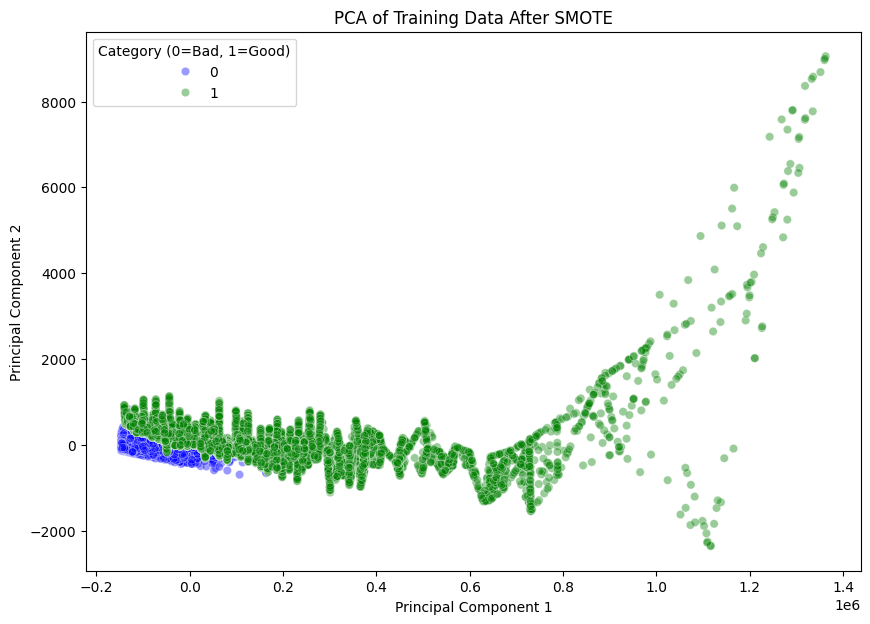

In [13]:
# Using PCA to visualize the resampled data into 2D
pca = PCA(n_components=2)
X_pca_res = pca.fit_transform(X_train_res)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_res[:, 0], y=X_pca_res[:, 1], hue=y_train_res, palette={1: 'green', 0: 'blue'}, alpha=0.4)
plt.title('PCA of Training Data After SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Category (0=Bad, 1=Good)')
plt.show()

# Supervised Learning

# Random Forest Classifier

In [14]:
# Initialize the Random Forest
# n_estimators = 100 means we are using 100 individual decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model using SMOTE balanced training data
rf_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred = rf_model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))


Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3890
           1       0.96      0.99      0.97       110

    accuracy                           1.00      4000
   macro avg       0.98      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



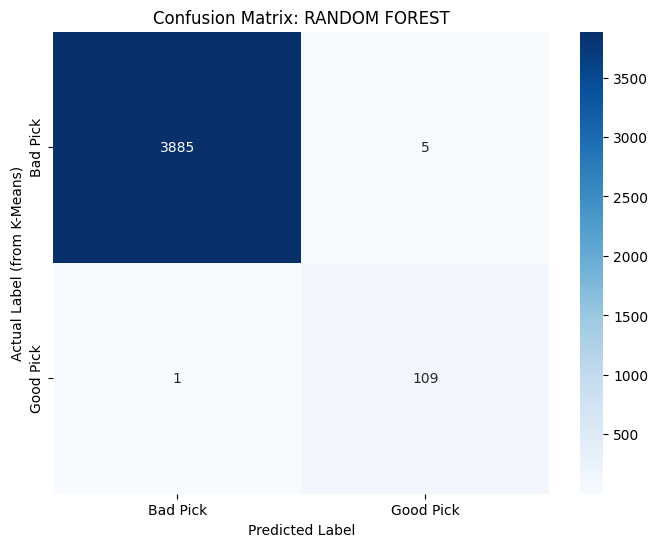

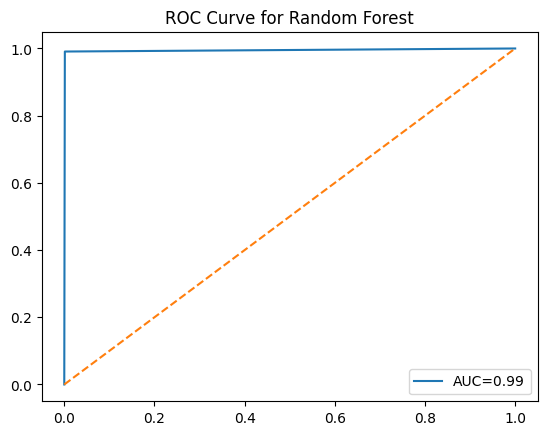

In [15]:
# Generating the matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Pick', 'Good Pick'],
            yticklabels=['Bad Pick', 'Good Pick'])
plt.title('Confusion Matrix: RANDOM FOREST')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label (from K-Means)')
plt.show()

# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title("ROC Curve for Random Forest")
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

## Ranking Candidates using Random Forest

In [16]:
# RANKING: Use the model to find the Top 5 Picks
# Get the probability of being Good (1 class)
df['Selection_Probability'] = rf_model.predict_proba(X)[:, 1]

# Sort by probability, then by Reputation
top_10_candidates_rfm = df.sort_values(by=['Selection_Probability'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates_rfm[['Display_Name', 'Reputation', 'Gold_Badges', 'Silver_Badges', 'Bronze_Badges', 'Selection_Probability']])


 TOP 10 CANDIDATE PICKS
           Display_Name  Reputation  Gold_Badges  Silver_Badges  \
120             Sarfraz      383564           81            561   
1012  android developer      116678          162            797   
3812        PositiveGuy       47943          113            318   
1310    Michael Durrant       97235          102            353   
2377              Cerin       65669          107            350   
3081         Harsha M V       55119          130            366   
3662         JasonDavis       49221          108            331   
1015       Thomas Owens      116533          100            322   
5058         Leon Gaban       39434          123            352   
1545          Snowcrash       87349          101            287   

      Bronze_Badges  Selection_Probability  
120             614                    1.0  
1012           1344                    1.0  
3812            480                    1.0  
1310            537                    1.0  
2377        

## DecisionTree

Decision Tree Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3890
           1       0.89      0.98      0.93       110

    accuracy                           1.00      4000
   macro avg       0.94      0.99      0.96      4000
weighted avg       1.00      1.00      1.00      4000



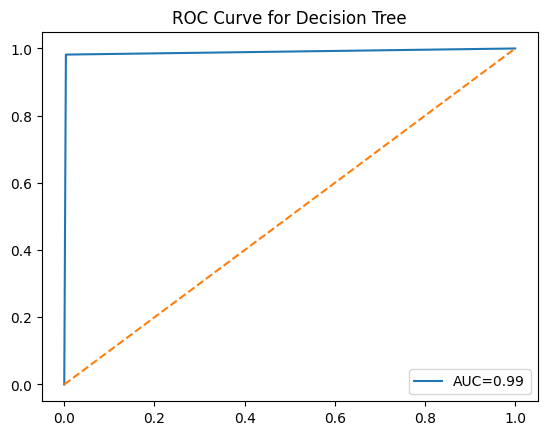


 TOP 10 CANDIDATE PICKS
         Display_Name  Reputation  Gold_Badges  Silver_Badges  Bronze_Badges  \
1725         sashoalm       80662          139            486            830   
1545        Snowcrash       87349          101            287            418   
1223  Alexander Mills      101704          167            549            940   
2407         aneuryzm       65052          101            284            502   
2790       pistacchio       59315          110            290            437   
3662       JasonDavis       49221          108            331            562   
1642          Vaccano       83350          163            513            930   
8008             Tiny       28079          113            352            612   
2772           code-8       59534          122            399            679   
2886              Run       57705          179            471            776   

      Selection_Probability_dt  
1725                       1.0  
1545                       1

In [17]:
# Initialize the Decision Tree
# max_depth limits how deep the tree can grow to prevent overfitting
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)

# Training the model using SMOTE balanced training data
dt_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Model Performance")
print(classification_report(y_test, y_pred_dt))

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.title("ROC Curve for Decision Tree")
plt.plot(fpr_dt, tpr_dt, label=f"AUC={roc_auc_dt:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 10 Picks
# Get the probability of being Good (1 class)
df['Selection_Probability_dt'] = dt_model.predict_proba(X)[:, 1]

# Sort by probability, then by Reputation
top_10_candidates_dt = df.sort_values(by=['Selection_Probability_dt'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates_dt[['Display_Name', 'Reputation', 'Gold_Badges', 'Silver_Badges', 'Bronze_Badges', 'Selection_Probability_dt']])

## XGBoost

XGBoost Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3890
           1       0.95      0.97      0.96       110

    accuracy                           1.00      4000
   macro avg       0.97      0.99      0.98      4000
weighted avg       1.00      1.00      1.00      4000



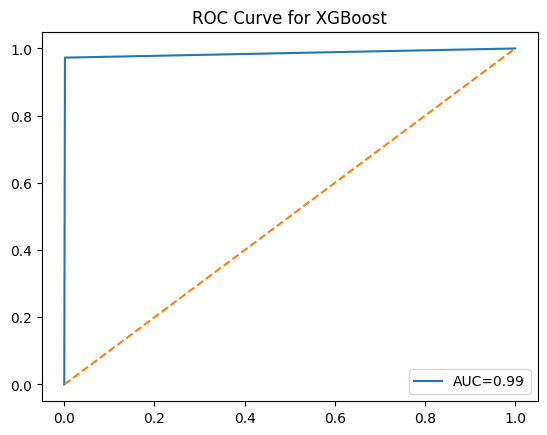


 TOP 10 CANDIDATE PICKS
                  Display_Name  Reputation  Gold_Badges  Silver_Badges  \
26                       Guffa      703275          113            760   
31  G&#252;nter Z&#246;chbauer      661786          235           2067   
2                  CommonsWare     1011493          195           2451   
3                 Greg Hewgill     1004481          193           1188   
4                      Quentin      949043          137           1280   
5                 Hans Passant      946843          151           1763   
6                        SLaks      891639          182           1947   
8                    paxdiablo      889416          243           1620   
9                Alex Martelli      888210          175           1253   
10                      unutbu      887011          197           1851   

    Bronze_Badges  Selection_Probability_xgb  
26           1025                        1.0  
31           1609                        1.0  
2            2684  

In [18]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)

# Training the model using SMOTE balanced training data
xgb_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Model Performance")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.title("ROC Curve for XGBoost")
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC={roc_auc_xgb:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 10 Picks
# Get the probability of being Good (1 class)
df['Selection_Probability_xgb'] = xgb_model.predict_proba(X)[:, 1]

# Sort by probability, then by Reputation
top_10_candidates_xgb = df.sort_values(by=['Selection_Probability_xgb'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates_xgb[['Display_Name', 'Reputation', 'Gold_Badges', 'Silver_Badges', 'Bronze_Badges', 'Selection_Probability_xgb']])

## Compare All Model Performances

MODEL PERFORMANCE COMPARISON

Random Forest:
  Accuracy:  0.999
  Precision: 0.956
  Recall:    0.991
  F1-Score:  0.973

Decision Tree:
  Accuracy:  0.996
  Precision: 0.885
  Recall:    0.982
  F1-Score:  0.931

XGBoost:
  Accuracy:  0.998
  Precision: 0.947
  Recall:    0.973
  F1-Score:  0.960
BEST MODEL: Random Forest (F1-Score: 0.973)

Model Comparison Table:
        Model  Accuracy  Precision   Recall  F1-Score
Random Forest   0.99850   0.956140 0.990909  0.973214
Decision Tree   0.99600   0.885246 0.981818  0.931034
      XGBoost   0.99775   0.946903 0.972727  0.959641


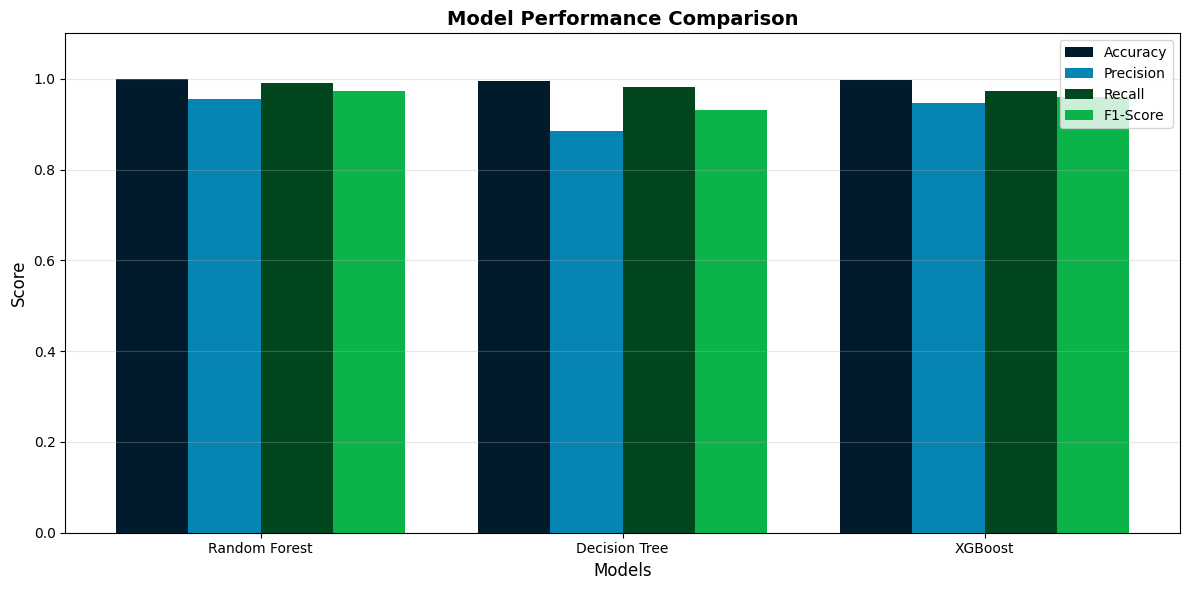


Using Random Forest for final predictions


In [19]:
print("MODEL PERFORMANCE COMPARISON")

models = {
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'XGBoost': xgb_model
}

# Store results
results = []
best_model_name = None
best_f1 = 0

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name

print(f"BEST MODEL: {best_model_name} (F1-Score: {best_f1:.3f})")

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ["#011b2d", "#0785B2", "#01461e", "#0ab448"]

for i, metric in enumerate(metrics):
    values = [r[metric] for r in results]
    ax.bar(x + i*width, values, width, label=metric, color=colors[i])

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([r['Model'] for r in results])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Use best model for final predictions
final_model = models[best_model_name]
print(f"\nUsing {best_model_name} for final predictions")

In [20]:
# Save model and scaler to pickle file
with open('stackoverflow_model.pkl', 'wb') as f:
    pickle.dump({'model': final_model, 'scaler': scaler}, f)

print("Model saved!")

Model saved!


## Importance Score

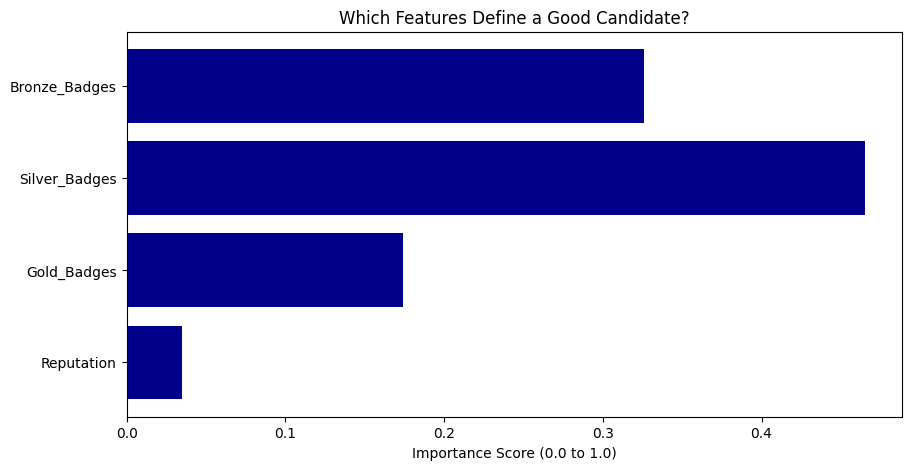

In [21]:
# Get importance scores
importances = rf_model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(all_features, importances, color='darkblue')
plt.title('Which Features Define a Good Candidate?')
plt.xlabel('Importance Score (0.0 to 1.0)')
plt.show()

# Export to CSV

In [22]:
# RANKING: Use the BEST Model (selected from comparison) to find the Top 10 Picks
# Note: Make sure you've run SNIPPET 3 first to define 'final_model' and 'best_model_name'

# Recalculate predictions using the best model
df['Selection_Probability'] = final_model.predict_proba(X)[:, 1]

# Sort by probability and get top 10
top_10_candidates = df.sort_values(by=['Selection_Probability'], ascending=False).head(10)

print(f"TOP 10 CANDIDATE PICKS (Using {best_model_name})")
print(top_10_candidates[['Display_Name', 'Reputation', 'Gold_Badges', 'Silver_Badges', 'Bronze_Badges', 'Selection_Probability']])

# Save the top 10 candidates to a CSV file
top_10_candidates.to_csv('../Shortlisted_candidates/stackoverflow_shortlisted_candidates.csv', index=False)

print(f"\nTop 10 candidates saved to 'stackoverflow_shortlisted_candidates.csv'")

TOP 10 CANDIDATE PICKS (Using Random Forest)
           Display_Name  Reputation  Gold_Badges  Silver_Badges  \
120             Sarfraz      383564           81            561   
1012  android developer      116678          162            797   
3812        PositiveGuy       47943          113            318   
1310    Michael Durrant       97235          102            353   
2377              Cerin       65669          107            350   
3081         Harsha M V       55119          130            366   
3662         JasonDavis       49221          108            331   
1015       Thomas Owens      116533          100            322   
5058         Leon Gaban       39434          123            352   
1545          Snowcrash       87349          101            287   

      Bronze_Badges  Selection_Probability  
120             614                    1.0  
1012           1344                    1.0  
3812            480                    1.0  
1310            537                  